In [118]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

In [119]:
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 8, 1)
s_p500 = yf.download(stocks, start=start, end=end, interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [120]:
ret = 100 * (s_p500.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()

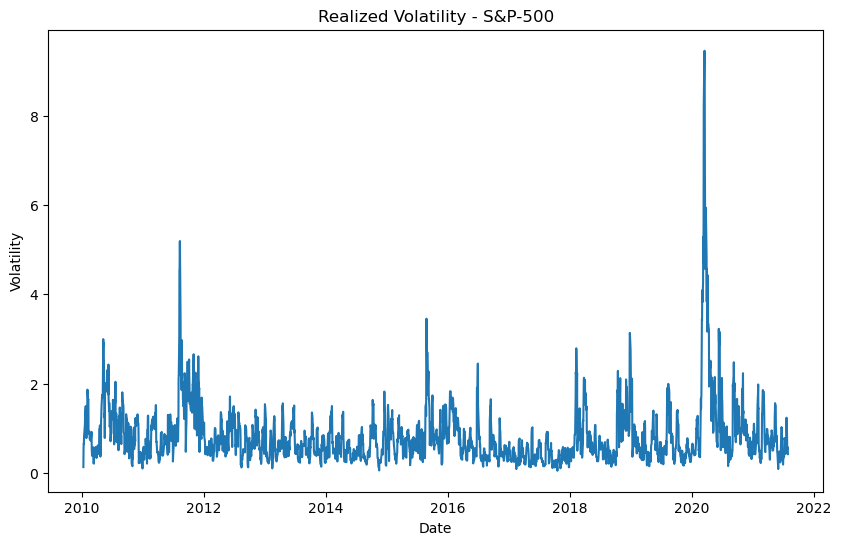

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index, realized_vol)
plt.title('Realized Volatility - S&P-500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [122]:
retv = ret.values

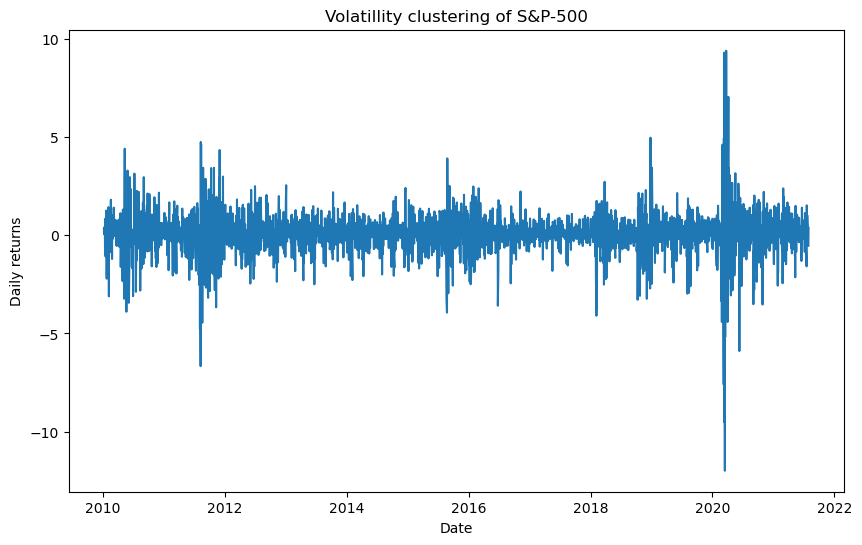

In [123]:
plt.figure(figsize=(10, 6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatillity clustering of S&P-500')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.show()

# ARCH model

In [124]:
n = 252
split_date = ret.iloc[-n:].index

In [125]:
sgm2 = ret.var()
K = ret.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 * (3.0 *sgm2 - K) * K)) / (6 * K)
omega = (1 - alpha) * sgm2
initial_parameters = [omega, alpha]
omega, alpha

(0.634156491639156, 0.46673132307801635)

In [126]:
@jit(nopython=True, parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0])
    alpha = abs(initial_parameters[1])
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t-1]) ** 2
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks

In [127]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

1388.8179801036479

In [128]:
def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args = (retv), method='Nelder-Mead', options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'.format(''.join(['-'] * 28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params

In [129]:
params = opt_params(initial_parameters, retv)


Results of Nelder-Mead minimization
----------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1384.4549042298167
             x: [ 7.016e-01  3.913e-01]
           nit: 24
          nfev: 47
 final_simplex: (array([[ 7.016e-01,  3.913e-01],
                       [ 7.015e-01,  3.912e-01],
                       [ 7.015e-01,  3.914e-01]]), array([ 1.384e+03,  1.384e+03,  1.384e+03]))

Resulting params = [0.70156719 0.39127836]


In [130]:
def arch_apply(ret):
    omega = params[0]
    alpha = params[1]
    T = len(ret)
    sigma2_arch = np.zeros(T+1)
    sigma2_arch[0] = np.var(ret)
    for t in range(1, T):
        sigma2_arch[t] = omega + alpha * ret[t-1] ** 2
    return sigma2_arch

In [131]:
sigma2_arch = arch_apply(ret)
sigma2_arch

array([1.18877935, 0.73955028, 0.70273161, ..., 0.70170294, 0.77079108,
       0.        ])

In [132]:
# using python function from arch package
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4061.27
Distribution:                  Normal   AIC:                           8126.54
Method:            Maximum Likelihood   BIC:                           8138.50
                                        No. Observations:                 2913
Date:                Mon, Aug 28 2023   Df Residuals:                     2913
Time:                        17:26:15   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7014  5.002e-02     14.023  1.129e-44 [  0.603,  0.79

In [133]:
bic_arch = []
for p in range(1, 5):
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
        best_param = p
arch = arch_model(ret,mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3709.51
Distribution:                  Normal   AIC:                           7429.03
Method:            Maximum Likelihood   BIC:                           7458.91
                                        No. Observations:                 2913
Date:                Mon, Aug 28 2023   Df Residuals:                     2913
Time:                        17:26:15   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2794  2.580e-02     10.829  2.498e-27   [  0.22

In [134]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_arch.variance.iloc[-len(split_date):] / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.0896


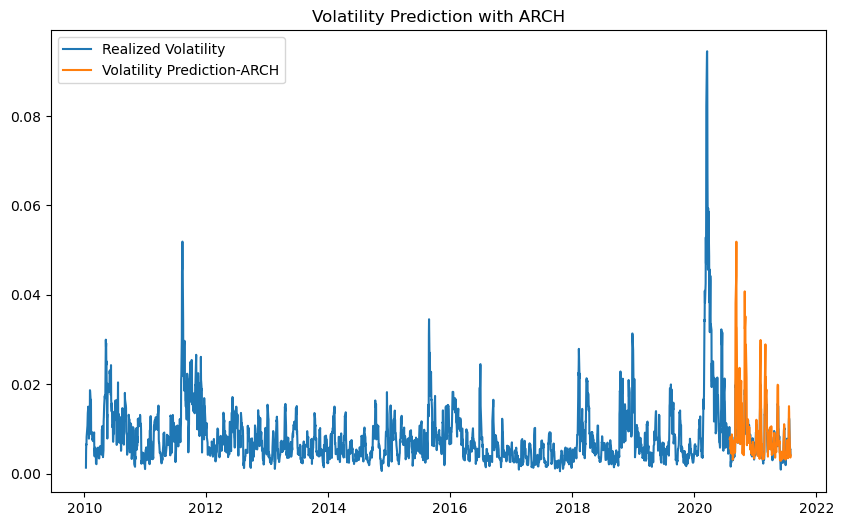

In [135]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

# GARCH

In [136]:
# backup omega and alpha to have possibility to restart from next cell
omega_bkp = omega
alpha_bkp = alpha

In [137]:
# restart point for GARCH
omega = omega_bkp
alpha = alpha_bkp

In [138]:
a0 = 0.0001
sgm2 = ret.var()
K = ret.kurtosis()
h = 1 - alpha / sgm2
alpha = np.sqrt(K * (1 - h ** 2) / (2.0 * (K + 3)))
beta = np.abs(h - omega)
omega = (1 - omega) * sgm2
initial_parameters = np.array([omega, alpha, beta])
print('Initial parameters for omega, alpha and beta are \n{}\n{}\n{}'.format(omega, alpha, beta))

Initial parameters for omega, alpha and beta are 
0.4350565592754937
0.5130099184547643
0.02663563269868552


In [139]:
retv = ret.values

In [140]:
@jit(nopython=True, parallel=True)
def garch_likelihood(initial_parameters, retv):
    omega = initial_parameters[0]
    alpha = initial_parameters[1]
    beta = initial_parameters[2]
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t-1]) ** 2 + beta * sigma2[t-1]
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks

In [141]:
logliks = garch_likelihood(initial_parameters, retv)
print('The Log likelihood id {:.4f}'.format(logliks))

The Log likelihood id 1386.4565


In [142]:
def garch_constraint(initial_parameters):
    omega = initial_parameters[0]
    alpha = initial_parameters[1]
    beta = initial_parameters[2]
    return np.array([1 - alpha - beta])

In [143]:
bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

In [144]:
def opt_paramsG(initial_parameters, retv):
    opt_result = opt.minimize(garch_likelihood, x0=initial_parameters, constraints=np.array([1 - alpha - beta]),
                              bounds=bounds, args=(retv), method='Nelder-Mead', options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'.format('-' * 35, opt_result))
    print('-' * 35)
    print('\nResulting parameters = {}'.format(params))
    return params

In [145]:
params = opt_paramsG(initial_parameters, retv)


Results of Nelder-Mead minimization
-----------------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 978.4381678874333
             x: [ 3.925e-02  1.744e-01  7.894e-01]
           nit: 99
          nfev: 172
 final_simplex: (array([[ 3.925e-02,  1.744e-01,  7.894e-01],
                       [ 3.929e-02,  1.745e-01,  7.893e-01],
                       [ 3.927e-02,  1.744e-01,  7.894e-01],
                       [ 3.928e-02,  1.744e-01,  7.894e-01]]), array([ 9.784e+02,  9.784e+02,  9.784e+02,  9.784e+02]))
-----------------------------------

Resulting parameters = [0.0392492  0.17440926 0.78939289]


In [146]:
def garch_apply(ret):
    omega = params[0]
    alpha = params[1]
    beta = params[2]
    T = len(ret)
    sigma2 = np.zeros(T + 1)
    sigma2[0] = np.var(ret)
    for t in range(1, T):
        sigma2[t] = omega + alpha * ret[t-1] ** 2 + beta * sigma2[t-1]
    return sigma2

In [147]:
# using python function from arch package
garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Mon, Aug 28 2023   Df Residuals:                     2913
Time:                        17:26:16   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [149]:
bic_garch = []
for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero', vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH', p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Mon, Aug 28 2023   Df Residuals:                     2913
Time:                        17:26:28   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [151]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_garch.variance.iloc[-len(split_date):] / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.0878


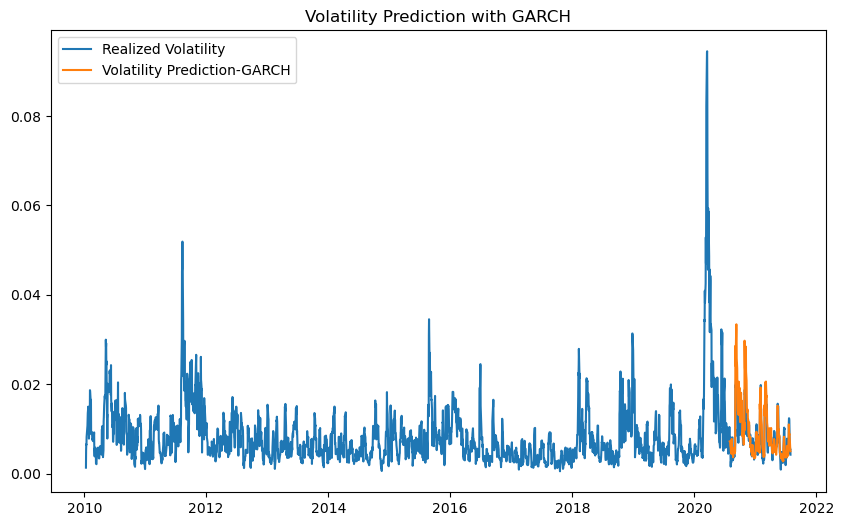

In [152]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()